# Random Forest Model Practice

### 1. Package load

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os
from tqdm import tqdm
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn import ensemble
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

### 2. Data Processing

#### 2-1) miRNA data processing(except STAD)

In [5]:
os.chdir('/home/sieunsung/git_sleunsung/mirna-tumor-purity-rf/data')

In [6]:
tumor_type = ['ACC', 'BLCA', 'BRCA', 'CESC', 'CHOL', 'COAD', 'DLBC', 'ESCA', 'GBM', 'HNSC', 'KICH', 'KIRP', 'LAML', 'LGG', 'LIHC', 'LUAD', 'LUSC', 'MESO', 'OV', 'PAAD', 'PCPG', 'PRAD', 'READ', 'SARC', 'SKCM', 'TGCT', 'THCA', 'THYM', 'UCEC', 'UCS', 'UVM']
df_list = []

for i in tumor_type:
    
    file_path = f'TCGA-{i}.mirna.tsv'
    
    if os.path.exists(file_path): 
        df = pd.read_csv(file_path, sep='\t')
        
        df.set_index('miRNA_ID', inplace=True)
        df = df.transpose()
        globals()[f'tumor_{i}'] = df
        df_list.append(df)
        
    df_all = pd.concat(df_list, ignore_index=False)
    

In [7]:
df_all.index.name = 'Sample ID'
df_all.reset_index(inplace=True)
df_all

miRNA_ID,Sample ID,hsa-let-7a-1,hsa-let-7a-2,hsa-let-7a-3,hsa-let-7b,hsa-let-7c,hsa-let-7d,hsa-let-7e,hsa-let-7f-1,hsa-let-7f-2,...,hsa-mir-941-5,hsa-mir-942,hsa-mir-943,hsa-mir-944,hsa-mir-95,hsa-mir-9500,hsa-mir-96,hsa-mir-98,hsa-mir-99a,hsa-mir-99b
0,TCGA-OR-A5JP-01A,13.675826,13.662729,13.686841,12.871630,10.488643,10.711859,12.736825,13.268208,13.294903,...,0.0,2.287204,0.000000,0.000000,1.015312,0.0,5.029521,6.674018,8.391438,16.858438
1,TCGA-OR-A5JG-01A,13.404831,13.398406,13.406791,13.445493,9.274417,9.835220,10.834714,12.947768,12.965911,...,0.0,3.212932,0.000000,0.000000,5.208153,0.0,1.055890,4.878414,8.235160,16.294555
2,TCGA-OR-A5K1-01A,13.509096,13.497735,13.513401,13.010596,10.589853,9.801843,11.677124,12.802651,12.857414,...,0.0,2.648827,0.297718,0.000000,2.977457,0.0,1.101646,6.779646,8.784837,16.338784
3,TCGA-OR-A5JR-01A,12.894686,12.907792,12.916945,12.431464,11.505636,10.076185,12.543761,12.496714,12.537543,...,0.0,1.867677,0.000000,0.267601,1.784773,0.0,1.603138,6.109995,10.327968,17.609554
4,TCGA-OR-A5KU-01A,12.347217,12.358603,12.360914,12.723436,8.311637,8.830809,11.265308,12.027105,12.028028,...,0.0,1.019343,0.000000,0.000000,3.644128,0.0,2.840357,5.754700,6.667404,16.184565
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9946,TCGA-WC-A87T-01A,15.089140,15.085523,15.084779,12.675119,13.614790,11.317512,12.709092,14.427833,14.453993,...,0.0,4.050011,0.000000,0.479266,2.467644,0.0,0.000000,6.939657,11.683356,15.306759
9947,TCGA-WC-AA9A-01A,14.944063,14.932934,14.941199,15.633610,9.634329,11.010797,11.214314,12.968774,13.007663,...,0.0,3.079447,0.000000,0.000000,1.164883,0.0,1.164883,5.960684,7.245213,15.597476
9948,TCGA-V4-A9EA-01A,15.185744,15.187512,15.196638,15.704901,13.856517,11.851992,11.291148,12.011830,12.038287,...,0.0,3.613499,0.000000,0.000000,3.208278,0.0,0.806790,5.964487,10.622107,15.953997
9949,TCGA-RZ-AB0B-01A,15.451510,15.448991,15.453677,15.353330,12.406350,10.489802,12.771268,13.747577,13.783336,...,0.0,2.164784,0.000000,0.175093,1.732340,0.0,2.205715,6.349064,10.597293,15.382622


#### 2-3) tumor purity

In [8]:
warnings.simplefilter("ignore")
purity = pd.read_excel("ncomms9971-s2.xlsx", skiprows = [0, 1, 2], usecols=["Sample ID", "CPE"] )

In [9]:
#### Remove NaN
purity_drop = purity.dropna(axis=0)
purity_drop

,Sample ID,CPE
0,TCGA-OR-A5J1-01A,0.9246
1,TCGA-OR-A5J2-01A,0.8985
2,TCGA-OR-A5J3-01A,0.9466
3,TCGA-OR-A5J4-01A,0.8660
4,TCGA-OR-A5J5-01A,0.9780
...,...,...
9359,TCGA-NF-A5CP-01A,0.7320
9360,TCGA-NG-A4VU-01A,0.8695
9361,TCGA-NG-A4VW-01A,0.7913
9362,TCGA-QM-A5NM-01A,0.9602


#### 2-4) miRNA+tumor purity

In [10]:
Input_data = pd.merge(df_all, purity_drop, on = 'Sample ID', how = 'inner')

In [11]:
Input_data

,Sample ID,hsa-let-7a-1,hsa-let-7a-2,hsa-let-7a-3,hsa-let-7b,hsa-let-7c,hsa-let-7d,hsa-let-7e,hsa-let-7f-1,hsa-let-7f-2,...,hsa-mir-942,hsa-mir-943,hsa-mir-944,hsa-mir-95,hsa-mir-9500,hsa-mir-96,hsa-mir-98,hsa-mir-99a,hsa-mir-99b,CPE
0,TCGA-OR-A5JP-01A,13.675826,13.662729,13.686841,12.871630,10.488643,10.711859,12.736825,13.268208,13.294903,...,2.287204,0.000000,0.000000,1.015312,0.0,5.029521,6.674018,8.391438,16.858438,0.9417
1,TCGA-OR-A5JG-01A,13.404831,13.398406,13.406791,13.445493,9.274417,9.835220,10.834714,12.947768,12.965911,...,3.212932,0.000000,0.000000,5.208153,0.0,1.055890,4.878414,8.235160,16.294555,0.9610
2,TCGA-OR-A5K1-01A,13.509096,13.497735,13.513401,13.010596,10.589853,9.801843,11.677124,12.802651,12.857414,...,2.648827,0.297718,0.000000,2.977457,0.0,1.101646,6.779646,8.784837,16.338784,0.8752
3,TCGA-OR-A5JR-01A,12.894686,12.907792,12.916945,12.431464,11.505636,10.076185,12.543761,12.496714,12.537543,...,1.867677,0.000000,0.267601,1.784773,0.0,1.603138,6.109995,10.327968,17.609554,0.8466
4,TCGA-OR-A5KU-01A,12.347217,12.358603,12.360914,12.723436,8.311637,8.830809,11.265308,12.027105,12.028028,...,1.019343,0.000000,0.000000,3.644128,0.0,2.840357,5.754700,6.667404,16.184565,0.9665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7758,TCGA-NF-A4WX-01A,11.958214,11.964497,12.006234,11.953787,11.551889,8.639947,11.036266,9.306848,9.375866,...,3.616921,0.244563,1.076152,3.456234,0.0,5.472895,4.889172,9.469817,16.793613,0.9371
7759,TCGA-N7-A59B-01A,12.029842,12.012369,12.053580,13.222032,9.619554,9.016087,9.893877,10.076653,10.199869,...,3.444207,0.000000,1.501041,1.069208,0.0,7.356775,6.346204,7.244578,15.949197,0.8806
7760,TCGA-ND-A4W6-01A,12.555478,12.539201,12.599002,13.217494,13.114832,9.202042,10.394415,10.783006,10.797131,...,3.189994,0.000000,1.289619,1.890910,0.0,4.332093,6.270613,10.676245,15.444474,0.6710
7761,TCGA-N9-A4Q8-01A,12.591661,12.568182,12.606694,13.330190,9.525195,9.470804,11.696850,11.080201,11.114043,...,2.711254,0.000000,0.311802,1.550928,0.0,6.596622,7.017809,7.220443,16.507582,0.9074


### 3. Data 준비

In [12]:
Input_data = pd.merge(df_all, purity_drop, on = 'Sample ID', how = 'inner') # miRNA + CPE + sample ID
X = Input_data.iloc[:, 1:1882]
y = Input_data.iloc[:]["CPE"]

In [13]:
X.head()

,hsa-let-7a-1,hsa-let-7a-2,hsa-let-7a-3,hsa-let-7b,hsa-let-7c,hsa-let-7d,hsa-let-7e,hsa-let-7f-1,hsa-let-7f-2,hsa-let-7g,...,hsa-mir-941-5,hsa-mir-942,hsa-mir-943,hsa-mir-944,hsa-mir-95,hsa-mir-9500,hsa-mir-96,hsa-mir-98,hsa-mir-99a,hsa-mir-99b
0,13.675826,13.662729,13.686841,12.871630,10.488643,10.711859,12.736825,13.268208,13.294903,9.203338,...,0.0,2.287204,0.000000,0.000000,1.015312,0.0,5.029521,6.674018,8.391438,16.858438
1,13.404831,13.398406,13.406791,13.445493,9.274417,9.835220,10.834714,12.947768,12.965911,9.100064,...,0.0,3.212932,0.000000,0.000000,5.208153,0.0,1.055890,4.878414,8.235160,16.294555
2,13.509096,13.497735,13.513401,13.010596,10.589853,9.801843,11.677124,12.802651,12.857414,9.534829,...,0.0,2.648827,0.297718,0.000000,2.977457,0.0,1.101646,6.779646,8.784837,16.338784
3,12.894686,12.907792,12.916945,12.431464,11.505636,10.076185,12.543761,12.496714,12.537543,10.056716,...,0.0,1.867677,0.000000,0.267601,1.784773,0.0,1.603138,6.109995,10.327968,17.609554
4,12.347217,12.358603,12.360914,12.723436,8.311637,8.830809,11.265308,12.027105,12.028028,9.422078,...,0.0,1.019343,0.000000,0.000000,3.644128,0.0,2.840357,5.754700,6.667404,16.184565


In [14]:
y.head()

0    0.9417
1    0.9610
2    0.8752
3    0.8466
4    0.9665
Name: CPE, dtype: float64

In [15]:
X.describe()

,hsa-let-7a-1,hsa-let-7a-2,hsa-let-7a-3,hsa-let-7b,hsa-let-7c,hsa-let-7d,hsa-let-7e,hsa-let-7f-1,hsa-let-7f-2,hsa-let-7g,...,hsa-mir-941-5,hsa-mir-942,hsa-mir-943,hsa-mir-944,hsa-mir-95,hsa-mir-9500,hsa-mir-96,hsa-mir-98,hsa-mir-99a,hsa-mir-99b
count,7763.000000,7763.000000,7763.000000,7763.000000,7763.000000,7763.000000,7763.000000,7763.000000,7763.000000,7763.000000,...,7763.0,7763.000000,7763.000000,7763.000000,7763.000000,7763.000000,7763.000000,7763.000000,7763.000000,7763.000000
mean,13.246069,13.242511,13.252638,13.719973,10.825340,9.294368,10.164058,11.713095,11.736255,9.195982,...,0.0,2.723169,0.106008,2.027280,2.296970,0.000162,4.037408,5.685829,8.832779,14.745881
std,0.838386,0.839180,0.836591,1.203527,1.840048,1.209569,1.166270,1.251410,1.252896,0.868429,...,0.0,1.183695,0.252333,2.666364,1.299924,0.010016,1.698507,1.017216,1.852958,1.378456
min,9.708723,9.674625,9.740723,8.725657,4.231385,4.290607,6.000260,5.033513,5.280172,4.869562,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.411608,9.582411
25%,12.682364,12.679932,12.691275,12.937878,9.624519,8.524604,9.398057,10.989054,11.011092,8.683911,...,0.0,1.818151,0.000000,0.000000,1.287234,0.000000,3.071517,5.207285,7.651602,13.795350
50%,13.196609,13.192151,13.200909,13.623617,10.889492,9.133213,10.080907,11.801513,11.827262,9.185033,...,0.0,2.694420,0.000000,0.836428,2.164345,0.000000,4.289851,5.767429,8.960184,14.587802
75%,13.763519,13.758837,13.765995,14.396931,12.116158,9.802198,10.902368,12.515026,12.537743,9.737297,...,0.0,3.560102,0.000000,2.419383,3.204858,0.000000,5.257550,6.319533,10.209918,15.507699
max,16.056144,16.053262,16.068488,18.685275,16.656879,15.847156,14.516050,15.801251,15.815818,12.173711,...,0.0,7.521135,3.253972,10.659408,7.720091,0.824692,9.418396,9.063527,13.930857,19.651945


### 4. Train/Test Data split

#### Train : Test = 7 : 3

In [16]:
#Train set / Test set 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=123)

In [17]:
#Data column 단위 정규화
normalizer = StandardScaler()
X_train = normalizer.fit_transform(X_train)
X_test = normalizer.transform(X_test)

print(f'Train set dimension is {X_train.shape}')
print(f'Test set dimension is {X_test.shape}')

Train set dimension is (5434, 1881)
Test set dimension is (2329, 1881)


### 5. Modeling

#### 5-1) 단순 모델링 (하이퍼파라미터 직접 정의)

In [18]:
rfr = RandomForestRegressor(n_estimators=100, criterion='squared_error', random_state=123, n_jobs=50)
rfr.fit(X_train, y_train)

RandomForestRegressor(n_jobs=50, random_state=123)

In [19]:
# Train set에 대한 성능
y_pred_train = rfr.predict(X_train)
train_mse = mean_squared_error(y_train, y_pred_train)
print("Train set에 대한 성능")  
print(f"평균 제곱 오차 (MSE): {train_mse:0.4f}")  

# Test set에 대한 성능
y_pred_test = rfr.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred_test)
print("\n")  
print("Test set에 대한 성능")  
print(f"평균 제곱 오차 (MSE): {test_mse:0.4f}")

Train set에 대한 성능
평균 제곱 오차 (MSE): 0.0010


Test set에 대한 성능
평균 제곱 오차 (MSE): 0.0071


#### 5-2) Grid search (단일 하이퍼파라미터)

100%|██████████| 9/9 [1:32:41<00:00, 617.90s/it]


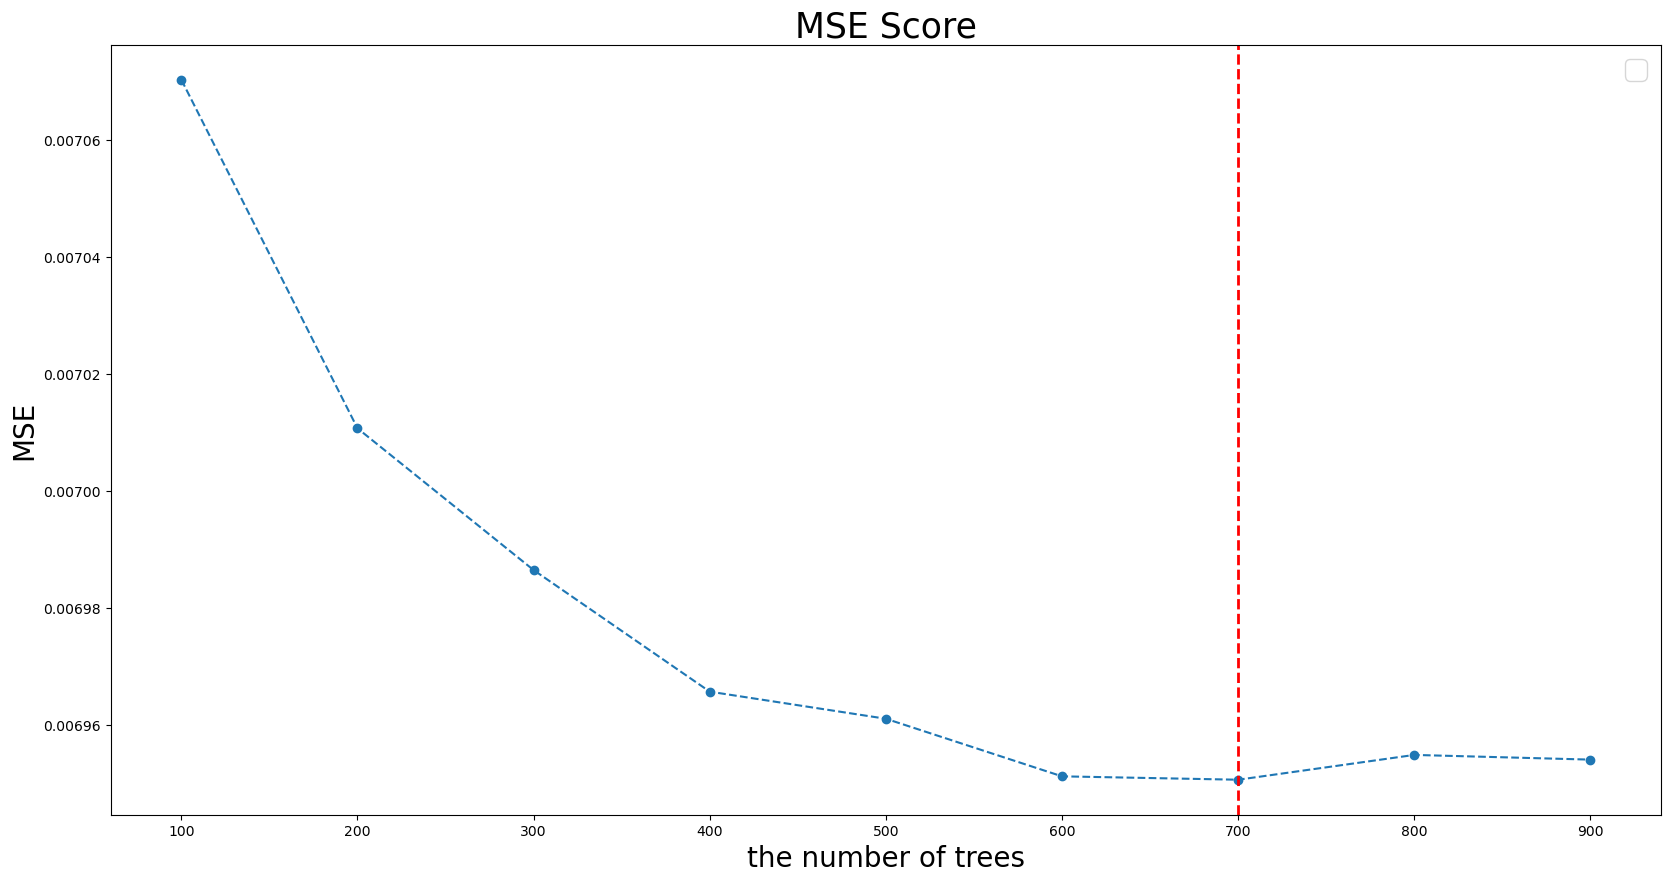

In [21]:
cv_scores = []
estimator_list =[i for i in range(100,1000,100)]
for i in tqdm(range(100,1000,100)):
    rfr = RandomForestRegressor (n_estimators=i+1,
                                 n_jobs=30,
                                 random_state=123)
    score = cross_val_score(rfr, X_train, y_train, cv=10, scoring = 'neg_mean_squared_error')
    cv_scores.append(-score.mean())

best_e = [estimator_list[i] for i in range(len(cv_scores)) if cv_scores[i] == np.min(cv_scores)]
plt.figure(figsize=(20,10))
plt.legend(["Cross validation scores"], fontsize=20)
plt.plot(estimator_list,cv_scores, marker='o', linestyle='dashed')
plt.xlabel("the number of trees", fontsize=20 )
plt.ylabel("MSE", fontsize=20)
plt.title("MSE Score", fontsize=25)
plt.axvline(best_e[0], color='r', linestyle='--', linewidth=2)
plt.show()

In [22]:
print(f"최적의 tree개수:{best_e}")
print("Train set에 대한 성능 (10 fold cross validation)")  
print(f"MSE:{max(cv_scores):0.4f}")  

최적의 tree개수:[700]
Train set에 대한 성능 (10 fold cross validation)
MSE:0.0071


In [23]:
rfr = RandomForestRegressor(n_estimators=700, n_jobs=2, random_state=123)
rfr.fit(X_train, y_train)

# Train set에 대한 성능
y_pred_train = rfr.predict(X_train)
train_mse = mean_squared_error(y_train, y_pred_train)
print("Train set에 대한 성능")  
print(f"평균 제곱 오차 (MSE): {train_mse:0.4f}")  

# Test set에 대한 성능
y_pred_test = rfr.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred_test)
print("\n")  
print("Test set에 대한 성능")  
print(f"평균 제곱 오차 (MSE): {test_mse:0.4f}")

Train set에 대한 성능
평균 제곱 오차 (MSE): 0.0009


Test set에 대한 성능
평균 제곱 오차 (MSE): 0.0070


#### 5-3) Grid search (파라미터 최적화)

In [29]:
rfr = RandomForestRegressor(random_state=123)

param_grid = {
    'n_estimators': [200, 700],
    'max_depth': [15, 20],
    'max_leaf_nodes': [50, 100],
    'criterion': ['squared_error'],
    'max_features': ['sqrt', 'log2', None]
}

CV_rfr = GridSearchCV(estimator=rfr, param_grid=param_grid, cv=10, verbose=1, n_jobs=50, error_score='raise', scoring='neg_mean_squared_error')

CV_rfr.fit(X_train, y_train)

Fitting 10 folds for each of 24 candidates, totalling 240 fits


GridSearchCV(cv=10, error_score='raise',
             estimator=RandomForestRegressor(random_state=123), n_jobs=50,
             param_grid={'criterion': ['squared_error'], 'max_depth': [15, 20],
                         'max_features': ['sqrt', 'log2', None],
                         'max_leaf_nodes': [50, 100],
                         'n_estimators': [200, 700]},
             scoring='neg_mean_squared_error', verbose=1)

In [30]:
#최적의 hyperparameter set 추출
CV_rfr.best_params_

{'criterion': 'squared_error',
 'max_depth': 15,
 'max_features': None,
 'max_leaf_nodes': 100,
 'n_estimators': 700}

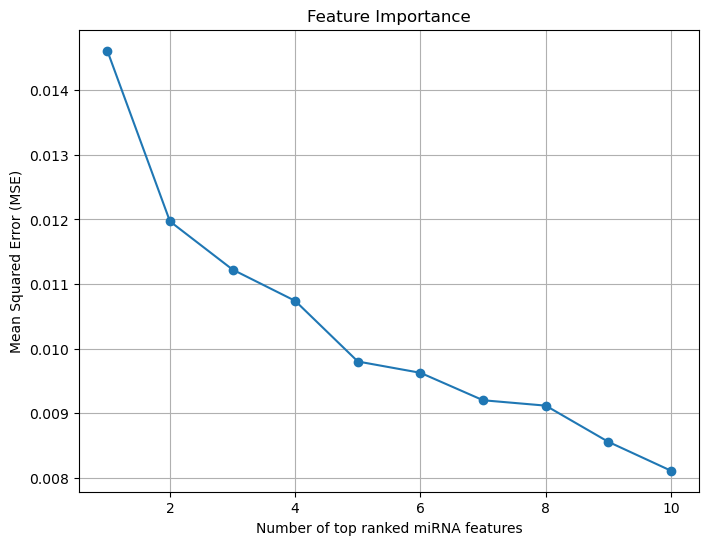

0.008111552876871214


In [32]:


# 데이터 병합 및 입력 데이터 설정
Input_data = pd.merge(df_all, purity_drop, on='Sample ID', how='inner')  # miRNA + CPE + sample ID
X = Input_data.iloc[:, 1:1882]
y = Input_data["CPE"]

top_features = [
    'hsa-mir-4772', 'hsa-mir-150', 'hsa-mir-155', 'hsa-mir-511', 'hsa-mir-21',
    'hsa-mir-142', 'hsa-mir-199a-1', 'hsa-mir-223', 'hsa-mir-92a-1', 'hsa-mir-200b'
]

# 데이터 분할 (훈련 세트와 테스트 세트)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# MSE 값을 저장할 리스트 초기화
mse_values = []

# 1부터 10까지 특징을 하나씩 추가하며 모델 학습 및 MSE 계산


for i in range(1, len(top_features) + 1):
  
    selected_features = top_features[:i]
    X_train_subset = X_train[selected_features]
    X_test_subset = X_test[selected_features]
    

    rfr_best = RandomForestRegressor(
        n_estimators=700,  
        criterion='squared_error',
        max_depth=15,
        max_features=None,
        max_leaf_nodes=100,
        random_state=123,
        n_jobs=50
    )
    rfr_best.fit(X_train_subset, y_train)
    

    y_pred = rfr_best.predict(X_test_subset)
    mse = mean_squared_error(y_test, y_pred)
    
    # MSE 
    mse_values.append(mse)

# MSE 값 플롯
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(top_features) + 1), mse_values, marker='o')
plt.title('Feature Importance')
plt.xlabel('Number of top ranked miRNA features')
plt.ylabel('Mean Squared Error (MSE)')
plt.grid(True)
plt.show()
print(mse)


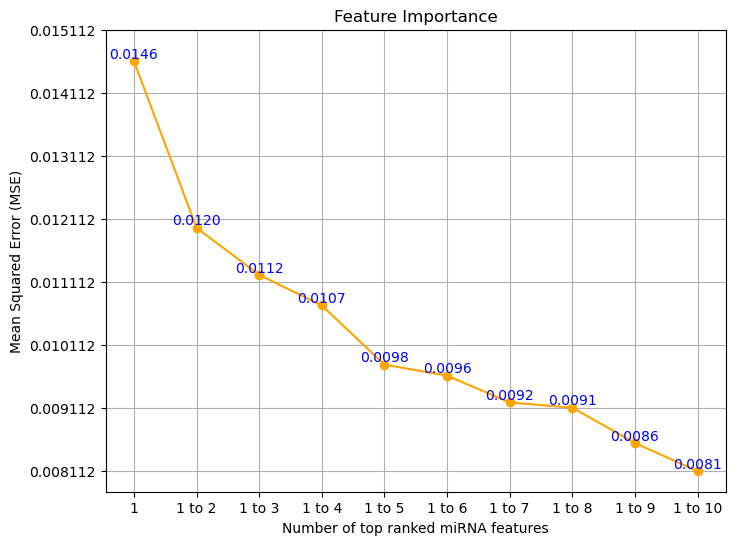

[0.014611359628780142, 0.011970317341505804, 0.01122424495139979, 0.010739782580794952, 0.009801697662055206, 0.009626667954073713, 0.009202097254659666, 0.009118800525597593, 0.008558610021949289, 0.008111552876871214]


In [33]:
import numpy as np

# X축 레이블 생성
x_labels = ['1'] + [f'1 to {i}' for i in range(2, len(top_features) + 1)]

# MSE 값 플롯
plt.figure(figsize=(8, 6))

# 플롯 생성
plt.plot(range(1, len(top_features) + 1), mse_values, marker='o', linestyle='-', color='orange')

# Y축 눈금 간격 조정
plt.yticks(np.arange(min(mse_values), max(mse_values) + 0.001, 0.001))

# 데이터 포인트마다 MSE 값 표시
for i, mse in enumerate(mse_values, 1):
    plt.text(i, mse, f'{mse:.4f}', ha='center', va='bottom', fontsize=10, color='blue')

# X축 레이블 설정
plt.xticks(range(1, len(top_features) + 1), x_labels)

plt.title('Feature Importance')
plt.xlabel('Number of top ranked miRNA features')
plt.ylabel('Mean Squared Error (MSE)')
plt.grid(True)
plt.show()

print(mse_values)


In [34]:
result_table = pd.DataFrame(CV_rfr.cv_results_)
result_table['MSE'] = -result_table['mean_test_score']

result_table = result_table.sort_values(by='MSE', ascending=False)
print(result_table[['params', 'MSE']])

                                               params       MSE
4   {'criterion': 'squared_error', 'max_depth': 15...  0.011853
16  {'criterion': 'squared_error', 'max_depth': 20...  0.011853
5   {'criterion': 'squared_error', 'max_depth': 15...  0.011756
17  {'criterion': 'squared_error', 'max_depth': 20...  0.011755
6   {'criterion': 'squared_error', 'max_depth': 15...  0.011136
18  {'criterion': 'squared_error', 'max_depth': 20...  0.011135
7   {'criterion': 'squared_error', 'max_depth': 15...  0.011037
19  {'criterion': 'squared_error', 'max_depth': 20...  0.011032
12  {'criterion': 'squared_error', 'max_depth': 20...  0.009172
0   {'criterion': 'squared_error', 'max_depth': 15...  0.009172
13  {'criterion': 'squared_error', 'max_depth': 20...  0.009153
1   {'criterion': 'squared_error', 'max_depth': 15...  0.009153
2   {'criterion': 'squared_error', 'max_depth': 15...  0.008649
14  {'criterion': 'squared_error', 'max_depth': 20...  0.008649
15  {'criterion': 'squared_error', 'max_

In [35]:
best_rfr = CV_rfr.best_estimator_
best_rfr.fit(X_train, y_train)

RandomForestRegressor(max_depth=15, max_features=None, max_leaf_nodes=100,
                      n_estimators=700, random_state=123)

In [41]:
best_rfr = RandomForestRegressor(random_state=123)
param_grid = {
    'n_estimators': [200, 700],
    'max_depth': [15, 20],
    'max_leaf_nodes': [50, 100],
    'criterion':['squared_error'],
    'max_features':['sqrt', 'log2', None]
}

{'criterion': 'squared_error',
 'max_depth': 15,
 'max_features': None,
 'max_leaf_nodes': 100,
 'n_estimators': 700}

{'criterion': 'squared_error',
 'max_depth': 15,
 'max_features': None,
 'max_leaf_nodes': 100,
 'n_estimators': 700}

In [37]:
# Train set에 대한 성능
y_pred_train = best_rfr.predict(X_train)
train_mse = mean_squared_error(y_train, y_pred_train)
print("Train set에 대한 성능")  
print(f"평균 제곱 오차 (MSE): {train_mse:0.4f}")  

# Test set에 대한 성능
y_pred_test = best_rfr.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred_test)
print("\n") 
print("Test set에 대한 성능")  
print(f"평균 제곱 오차 (MSE): {test_mse:0.4f}")

Train set에 대한 성능
평균 제곱 오차 (MSE): 0.0042


Test set에 대한 성능
평균 제곱 오차 (MSE): 0.0078


In [49]:
if not hasattr(rfr_best, "estimators_"): 
    print("Fitting the model...")
    rfr_best.fit(X_train, y_train)

Fitting the model...


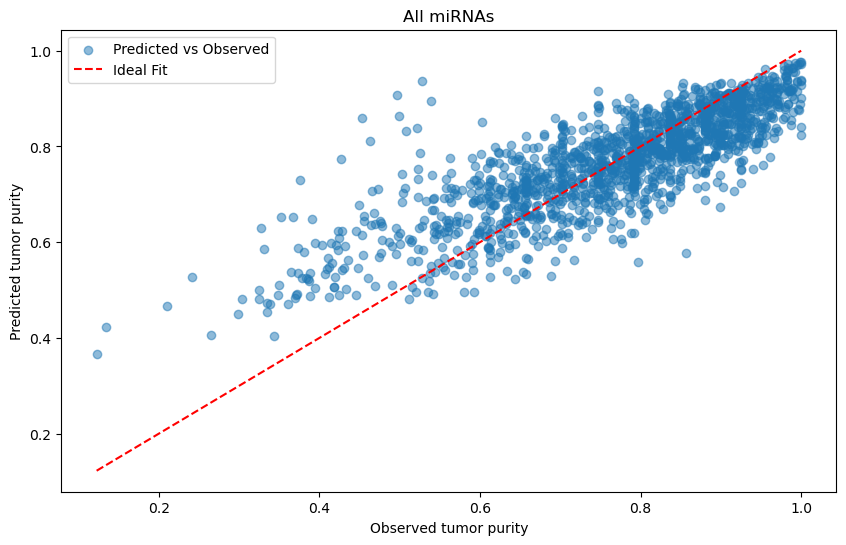

In [50]:
# 예측값 생성
y_pred = rfr_best.predict(X_test)

# Scatter plot 그리기
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label="Predicted vs Observed")
plt.xlabel("Observed tumor purity")
plt.ylabel("Predicted tumor purity")
plt.title("All miRNAs")

# 1:1 대각선 기준선 추가
min_val = min(min(y_test), min(y_pred))
max_val = max(max(y_test), max(y_pred))
plt.plot([min_val, max_val], [min_val, max_val], color="red", linestyle="--", label="Ideal Fit")

# 범례 추가
plt.legend()
plt.show()

#### Feature importance

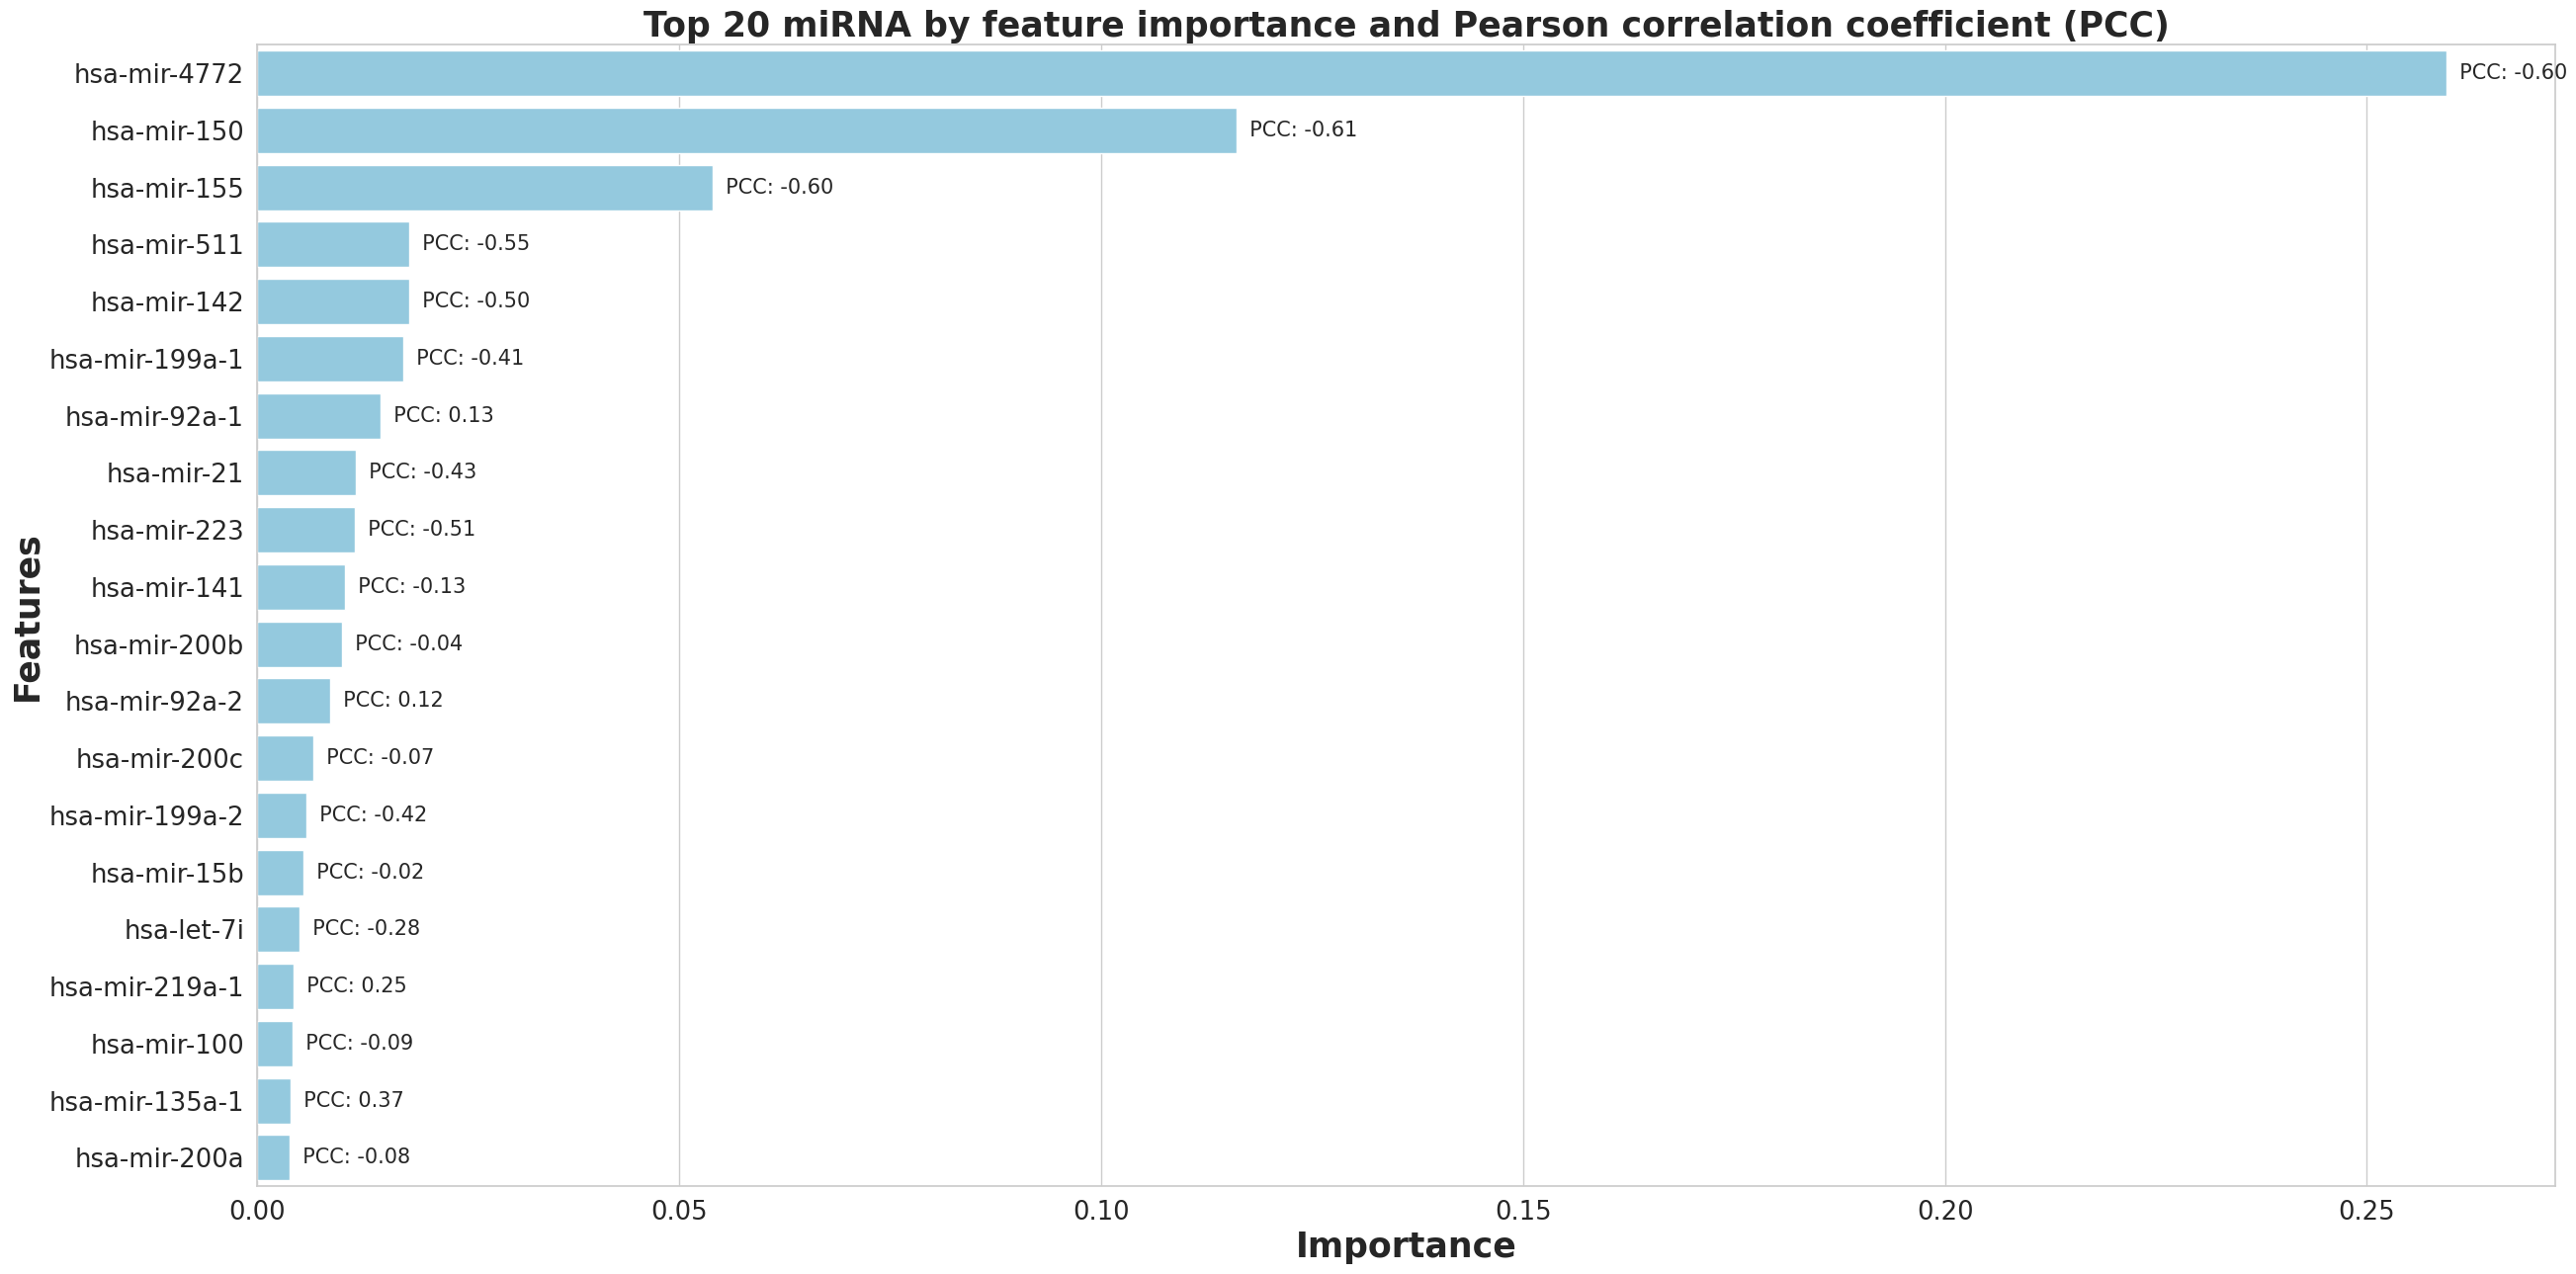

,Features,Gini-Importance,PCC
0,hsa-mir-4772,0.259387,-0.600638
1,hsa-mir-150,0.116017,-0.608827
2,hsa-mir-155,0.053920,-0.604044
3,hsa-mir-511,0.017963,-0.551217
4,hsa-mir-142,0.017957,-0.500623
5,hsa-mir-199a-1,0.017328,-0.414143
6,hsa-mir-92a-1,0.014555,0.125302
7,hsa-mir-21,0.011688,-0.429095
8,hsa-mir-223,0.011583,-0.510694
9,hsa-mir-141,0.010413,-0.125945


In [51]:
feats = {}
for feature, importance in zip(X.columns, rfr_best.feature_importances_):
    feats[feature] = importance

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False).head(20)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})

# PCC
pcc_values = []
for feature in importances['Features']:
    pcc = X[feature].corr(y)
    pcc_values.append(pcc)

importances['PCC'] = pcc_values

sns.set(font_scale=5)
sns.set(style="whitegrid", color_codes=True, font_scale=1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30, 15)

sns.barplot(x='Gini-Importance', y='Features', data=importances, color='skyblue', ax=ax)

for i, (importance, pcc) in enumerate(zip(importances['Gini-Importance'], importances['PCC'])):
    ax.text(importance, i, f'  PCC: {pcc:.2f}', va='center', fontsize=15)

plt.xlabel('Importance', fontsize=25, weight='bold')
plt.ylabel('Features', fontsize=25, weight='bold')
plt.title('Top 20 miRNA by feature importance and Pearson correlation coefficient (PCC)', fontsize=25, weight='bold')
plt.show()

importances


### 6. 타 알고리즘과의 비교

##### KNN

In [52]:
rfr = KNeighborsRegressor(n_neighbors = 5, p=2)
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)

MSE = mean_squared_error(y_true = y_test, y_pred =y_pred)

print('KNN')
print(f"MSE: {MSE:.4f}")

KNN
MSE: 0.0113


##### Decision Tree

In [54]:
from sklearn.tree import DecisionTreeRegressor

classifier = DecisionTreeRegressor(random_state=123)
param_grid = {
    'max_depth': [15,20,30],
    'max_leaf_nodes': [50, 100],
    'criterion':['squared_error', 'mae']
}

CV_Regressor = GridSearchCV(estimator=DecisionTreeRegressor(random_state=123), param_grid=param_grid, cv=10, verbose=1, n_jobs=50)
CV_Regressor.fit(X_train, y_train)

best_Regressor = CV_Regressor.best_estimator_
best_Regressor.fit(X_train, y_train)

y_pred = best_Regressor.predict(X_test)

MSE = mean_squared_error(y_true = y_test, y_pred =y_pred)
MAE = mean_absolute_error(y_true = y_test, y_pred =y_pred)

print('Decision Tree')
print(f"MSE:{MSE:0.4f}", sep='  |  ')  
print(f"MAE:{MAE:0.4f}", sep='  |  ')  

Fitting 10 folds for each of 12 candidates, totalling 120 fits
Decision Tree
MSE:0.0110
MAE:0.0787
